first create a structured mesh of n*m cells.
for example: is a 6X3 mesh


In [60]:
import numpy as np

# _ _ _ _ _ _
#|_|_|_|_|_|_|
#|_|_|_|_|_|_|
#|_|_|_|_|_|_|

n_rows        = 30
n_columns     = 60
n_nodes       = n_rows*n_columns
conductivity  = 237 #alu w/m/k
starting_temp = 273

# spacing between nodes
dx = 1
dy = 1
dz = 1

there are:  
18 elements, and therefore 18 nodes.  
18 (2*n+2*m=) boundary faces  
(n-1)*m + (m-1)*n internal faces.  
(n+1) * (m+1) verticies

The unknown quantity (Temperature for this case) is stored at the cell centres (nodes).
An array for each governing equation should be created.

The general continuum transport equation per unit volume to be solved for some quantity $\phi$ is as follows:
$$
\frac{\partial (\rho \phi)}{\partial t} + \nabla \cdot (\rho v \phi) = \nabla\cdot(\Gamma^\phi \nabla_\phi) + Q^\phi
$$

For temperature diffusion through a solid in the steady state, the time derivive of $\phi$ and the velocity ($v$) is zero and therefore the unsteady and the convective terms drop out leaving:

$$
-\nabla\cdot(\Gamma^\phi \nabla_\phi) = Q^\phi 
$$

which means the divergance of the gradient of the scalar field $\phi$ (the gradient of a scalar field is a vector field) multiplied by the diffusion coefficient $\Gamma^\phi$ is equal to the source term.

Moving from the generalized equation to one for temperature then gives:
$$
-\nabla\cdot(k \nabla_T) = \dot q
$$
where the diffusion coefficient is replaced with the thermal conductivity $k$ and the source term with the dissipation per unit volume $\dot q$.

Because this equation is linear, it fits into the matrix form. Non linear terms would need to first be linearized (radiation for example) 
$$
A[T] = b
$$

The equation is then integrated over a control volume ( a single element) and using the divergence theorem to replace the divergence operation with a surface integral to obtain the energy balance.
Approximating the surface integral with a sum over the faces of the control volume yields:
$$
-\sum_{f~nb(C)} (k\nabla T)_f \cdot S_f = \dot q_C V_C
$$

meaning that for each face $f$ of the control volume, the dot product of the temperature gradient (at the face) when multiplied with the thermal conductivity and the surface area of the face multiplied by the normal vector, will be equal to the dissipation within the cell multiplied by the volume. 

Because i want a structured grid that varies in the y and x directions to fit the curve 
of a 2d axisymmetric thruster, 2 additional arrays.
The structured grid is represented by 1d arrays
the node variables are stored in a n*m grid.  

to begin we assume a isotropic grid with unit distance between nodes in each direction.
The first step is then to assemble the global matrix

 
$$

In [61]:
# the coefficient matrix
node_gamma = np.zeros([n_nodes, n_nodes])

# the variable vector
node_phi   = np.full((n_nodes), starting_temp)

# the constant vector (source terms)
node_b     = np.full((n_nodes), 0)

for row in range(n_rows):
    for column in range(n_columns):
        node_id_C = row*n_columns + column
        ac = 0

        # insert right neighbor into A
        if column < n_columns -1:
            node_id_R = node_id_C + 1
            a1 = -conductivity * (dy*dz) / dx #GL to right neighbor
            node_gamma[node_id_C][node_id_R] = a1
            ac += a1

        #insert up neighbor into A
        if row > 0:
            a2 = -conductivity * (dx*dz) / dy #GL to up neighbor
            node_id_U = node_id_C - n_columns
            node_gamma[node_id_C][node_id_U] = a2
            ac += a2

        #insert left neighbor into A
        if column > 0:
            a3 = -conductivity * (dy*dz) / dx #GL to left neighbor
            node_id_L = node_id_C - 1
            node_gamma[node_id_C][node_id_L] = a3
            ac += a3

        # insert down neighbor into A
        if row < n_rows -1:
            a4 = -conductivity * (dx*dz) / dy #GL to down neighbor
            node_id_D = node_id_C + n_columns 
            node_gamma[node_id_C][node_id_D] = a4
            ac += a4

        #insert this cell into A
        node_gamma[node_id_C][node_id_C] = -ac

#np.savetxt("node_gamma.csv", node_gamma, delimiter=",")


The solver to be used is the gauss siedel.

In [62]:
def gauss_seidel(A, b, x0, epsilon, max_iterations):
    n = len(A)
    x = x0.copy()

    #Gauss-Seidal Method [By Bottom Science]

    for i in range(max_iterations):
        x_new = np.zeros(n)
        for j in range(n):
            if j == 0:
                x_new[j]  = starting_temp
                continue

            if j == n-1:
                x_new[j]  = 50
                continue
            
            s1 = np.dot(A[j, :j], x_new[:j])
            s2 = np.dot(A[j, j + 1:], x[j + 1:])
            x_new[j] = (b[j] - s1 - s2) / A[j, j]

        if np.allclose(x, x_new, rtol=epsilon):
            print("converged after: " +str(i) + " iterations")
            return x_new
        x = x_new
    return x

In [64]:
T = gauss_seidel(node_gamma, node_b, node_phi, 1e-5,1000)

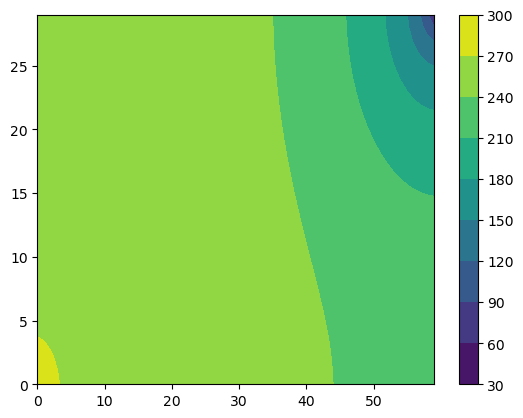

In [66]:
import matplotlib.pyplot as plt

plt.contourf(np.reshape(T, (-1, n_columns)))
plt.colorbar()
plt.show()